In [1]:
import random
import torch

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
hidden_dims = set()

random.seed(seed)
torch.manual_seed(seed)

In [4]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)
train_eps = env.expert.num_eps
train_eps

1101

In [5]:
# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [6]:
# Z_sets = find_sequential_pi_backdoor(G, X, Y, obs_prefix)

In [7]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [8]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    behavioral_policy=None,
    seed=seed
)

In [9]:
hidden_size = 512
lr = 1e-4
batch_size = 512
patience = 40
lookback = 5
num_blocks = 6

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'X': 8
}

In [10]:
# causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
#     records,
#     Z_sets,
#     dims=dims,
#     epochs=200,
#     include_vars=obs_prefix,
#     lookback=lookback,
#     continuous=True,
#     num_actions = env.action_space.shape[0],
#     hidden_dim=hidden_size,
#     num_blocks=num_blocks,
#     dropout=0.0,
#     lr=lr,
#     batch_size=batch_size,
#     patience=patience,
#     device=device,
#     seed=seed,
#     action_bounds=(env.action_space.low, env.action_space.high)
# )

# causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
# causal_policies = make_shared_policy_dict(causal_policy)

In [11]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    epochs=200,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=0.0,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

[LongHorizon] Early stop at epoch 61; best val 0.045514.


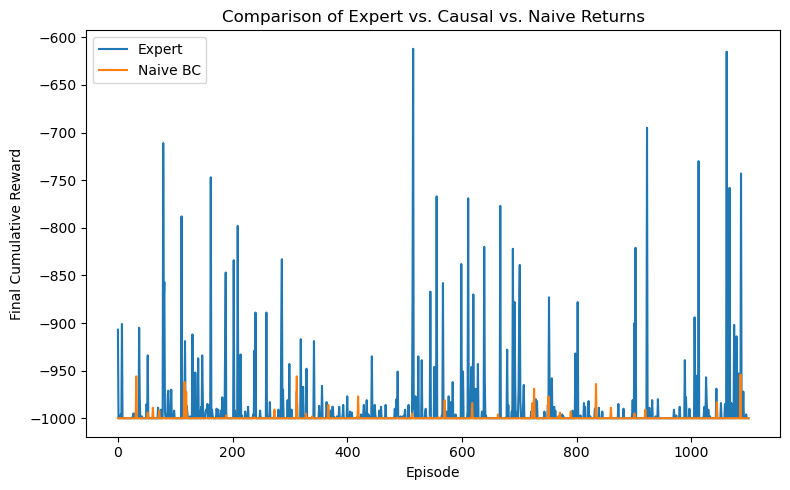

In [12]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

# causal_records = collect_imitator_trajectories(env, causal_policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
# causal_episode_rewards = defaultdict(float)
# for rec in causal_records:
#     ep = rec['episode']
#     causal_episode_rewards[ep] += float(rec['reward'])

# causal_rewards = [causal_episode_rewards[e] for e in range(num_eps)]

naive_records = collect_imitator_trajectories(env, naive_policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
naive_episode_rewards = defaultdict(float)
for rec in naive_records:
    ep = rec['episode']
    naive_episode_rewards[ep] += float(rec['reward'])

naive_rewards = [naive_episode_rewards[e] for e in range(num_eps)]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
# plt.plot(causal_rewards, label='Causal BC')
plt.plot(naive_rewards, label='Naive BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# sum(expert_rewards)/num_eps, sum(causal_rewards)/num_eps, sum(naive_rewards)/num_eps
sum(expert_rewards)/num_eps, sum(naive_rewards)/num_eps

(-989.9872842870118, -999.5531335149864)

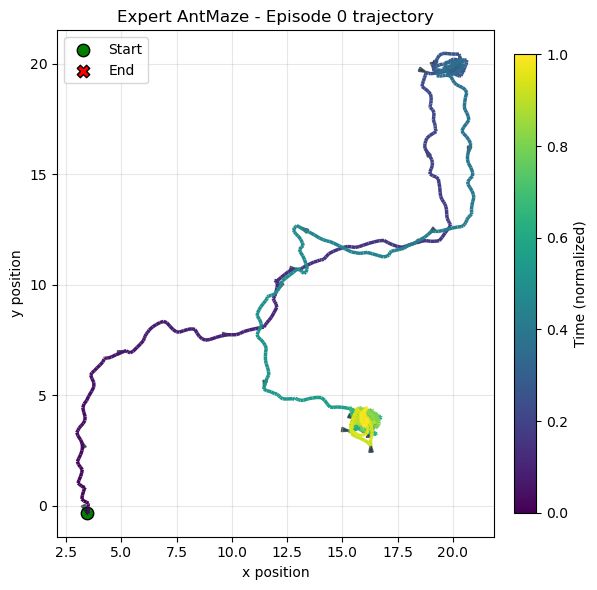

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    """
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    """
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix="AntMaze"):
    """
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    """
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Time (normalized)")

    ax.set_aspect('equal', 'box')
    ax.set_xlabel("x position")
    ax.set_ylabel("y position")
    ax.set_title(f"{title_prefix} - Episode {episode_id} trajectory")
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

fig, ax = plot_ant_trajectory_xy(records, episode_id=0, title_prefix="Expert AntMaze")
plt.show()

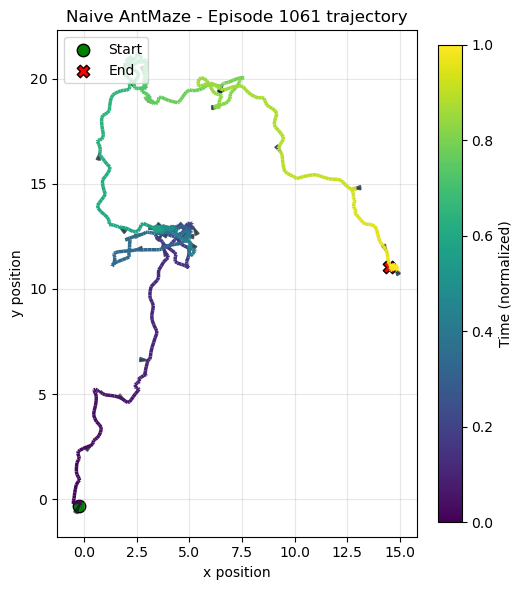

In [88]:
fig, ax = plot_ant_trajectory_xy(naive_records, episode_id=np.random.randint(0, 1102), title_prefix="Naive AntMaze")
plt.show()